In [1]:
import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import numpy as np
import pandas as pd
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

## Parameters and path

In [5]:
um_per_pixel = 0.117
s_per_frame = 0.02
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig1_system design/c_boundary_w_RNAtracks/"
os.chdir(folder_save)

# load dataset
fname_RNA = "SPT_results_AIO-20221031-FL_noTR_noDex_20ms_0hr_Replicate1_FOV-7-RNAs.csv"
fname_condensate = "condensates_AIO-20221031-FL_noTR_noDex_20ms_0hr_Replicate1_FOV-7-condensates_AveProj_Simple Segmentation.csv"

df_RNA = pd.read_csv(fname_RNA)
df_condensate = pd.read_csv(fname_condensate)

# color
line_color = "gray"
scalebar_color = "black"
# cmap_color_start = "#f6f0ca"
# cmap_color_end = "#c61a3e"
# cmap_name = "cream2thrusd"
# cmap_color_start = "#EDB9B1"
# cmap_color_end = "#9a3324"
# cmap_name = "red_series"
cmap_color_end = "#00274c"
cmap_color_start = "#ffcb05"
cmap_name = "maize2blue"
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
    N=200,
)

# scale bar
scalebar_length_um = 1
um_per_pixel = 0.117
scalebar_length_pxl = scalebar_length_um / um_per_pixel

## Functions

In [3]:
def list_like_string_to_xyt(list_like_string):
    # example list_like_string structure of xyt: '[0, 1, 2, 3]'
    list_of_xyt_string = list_like_string[1:-1].split(", ")
    lst_xyt = []
    for xyt_string in list_of_xyt_string:
        lst_xyt.append(float(xyt_string))

    return np.array(lst_xyt, dtype=float)

# Overview Plot

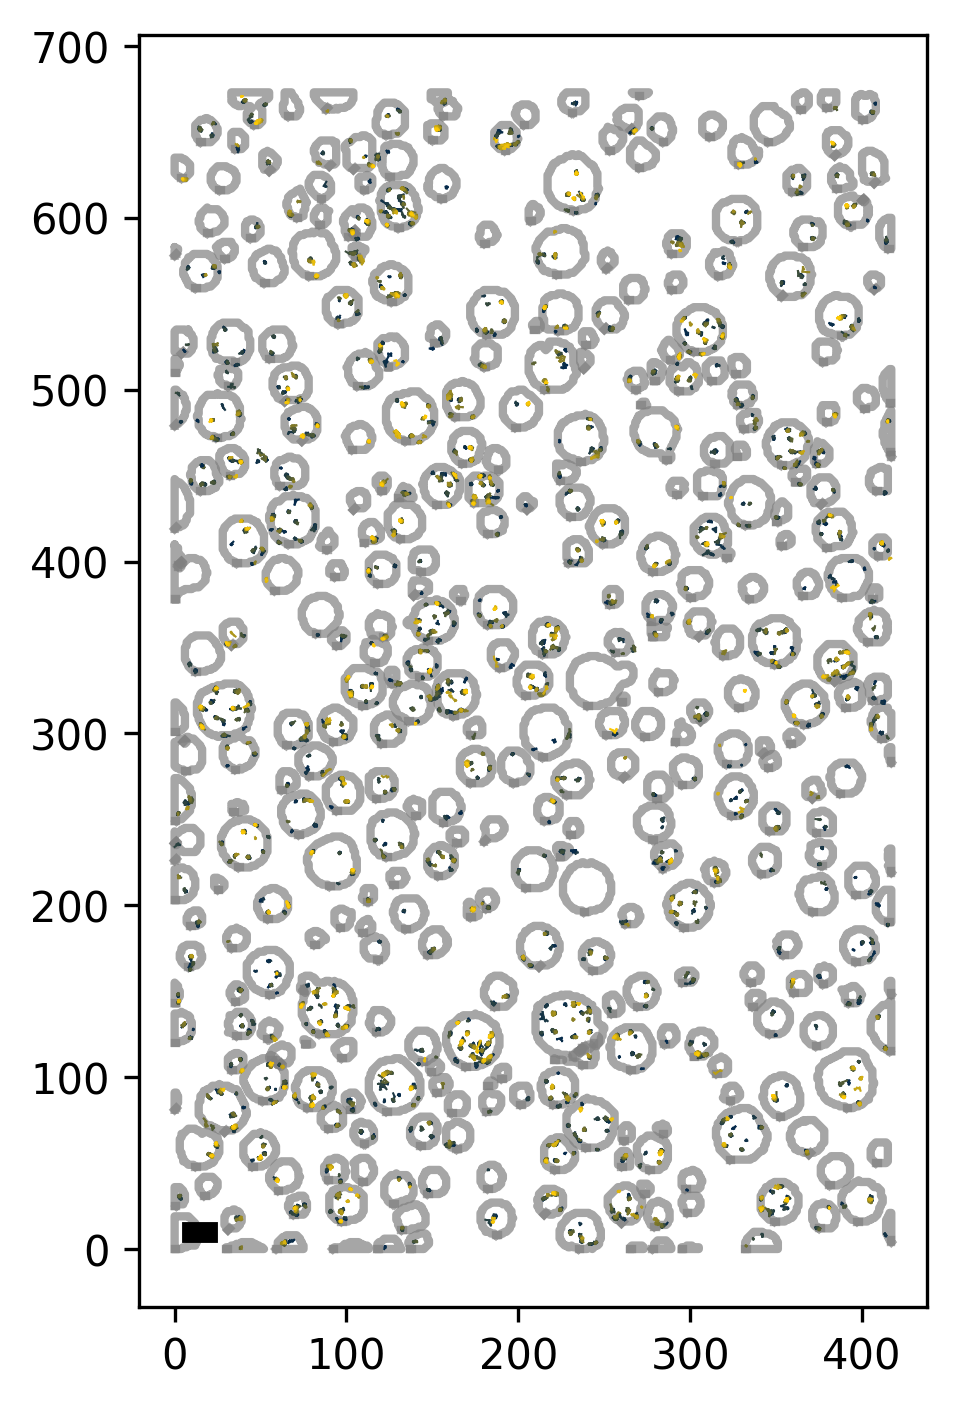

In [44]:
# full size: 418x674
zoom_in_x = (0, 418)
zoom_in_y = (0, 674)

plt.figure(dpi=300)
## plot condensate boundaries
for condensateID in track(
    df_condensate["condensateID"].unique(), description="Plot condensates"
):
    str_condensate_coords = df_condensate[
        df_condensate["condensateID"] == condensateID
    ]["contour_coord"].squeeze()
    x = []
    y = []
    for str_condensate_xy in str_condensate_coords[2:-2].split("], ["):
        xy = str_condensate_xy.split(", ")
        x.append(int(xy[0]))
        y.append(int(xy[1]))
    plt.plot(x, y, "-", color=line_color, linewidth=2, alpha=0.7)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color=line_color, linewidth=2, alpha=0.7)
# plt.xlim(0, 418)
# plt.ylim(0, 674)

## plot RNA tracks
for _, row in track(df_RNA.iterrows(), description="Plot RNAs"):
    x = list_like_string_to_xyt(row["list_of_x"])
    y = list_like_string_to_xyt(row["list_of_y"])
    t = list_like_string_to_xyt(row["list_of_t"])

    for i in range(len(t) - 1):
        if (
            (x[i] > zoom_in_x[0])
            & (x[i] < zoom_in_x[1])
            & (y[i] > zoom_in_y[0])
            & (y[i] < zoom_in_y[1])
        ):
            plt.plot(
                x[i : i + 2],
                y[i : i + 2],
                "-",
                color=cmap(np.mean(t[i : i + 2]) / 200),
                linewidth=0.5,
            )

plt.tight_layout()
plt.axis("scaled")

# plot scale bar
plt.plot([10, 10 + scalebar_length_pxl], [10, 10], "-", color=scalebar_color, lw=5)

plt.show()

# Zoom in

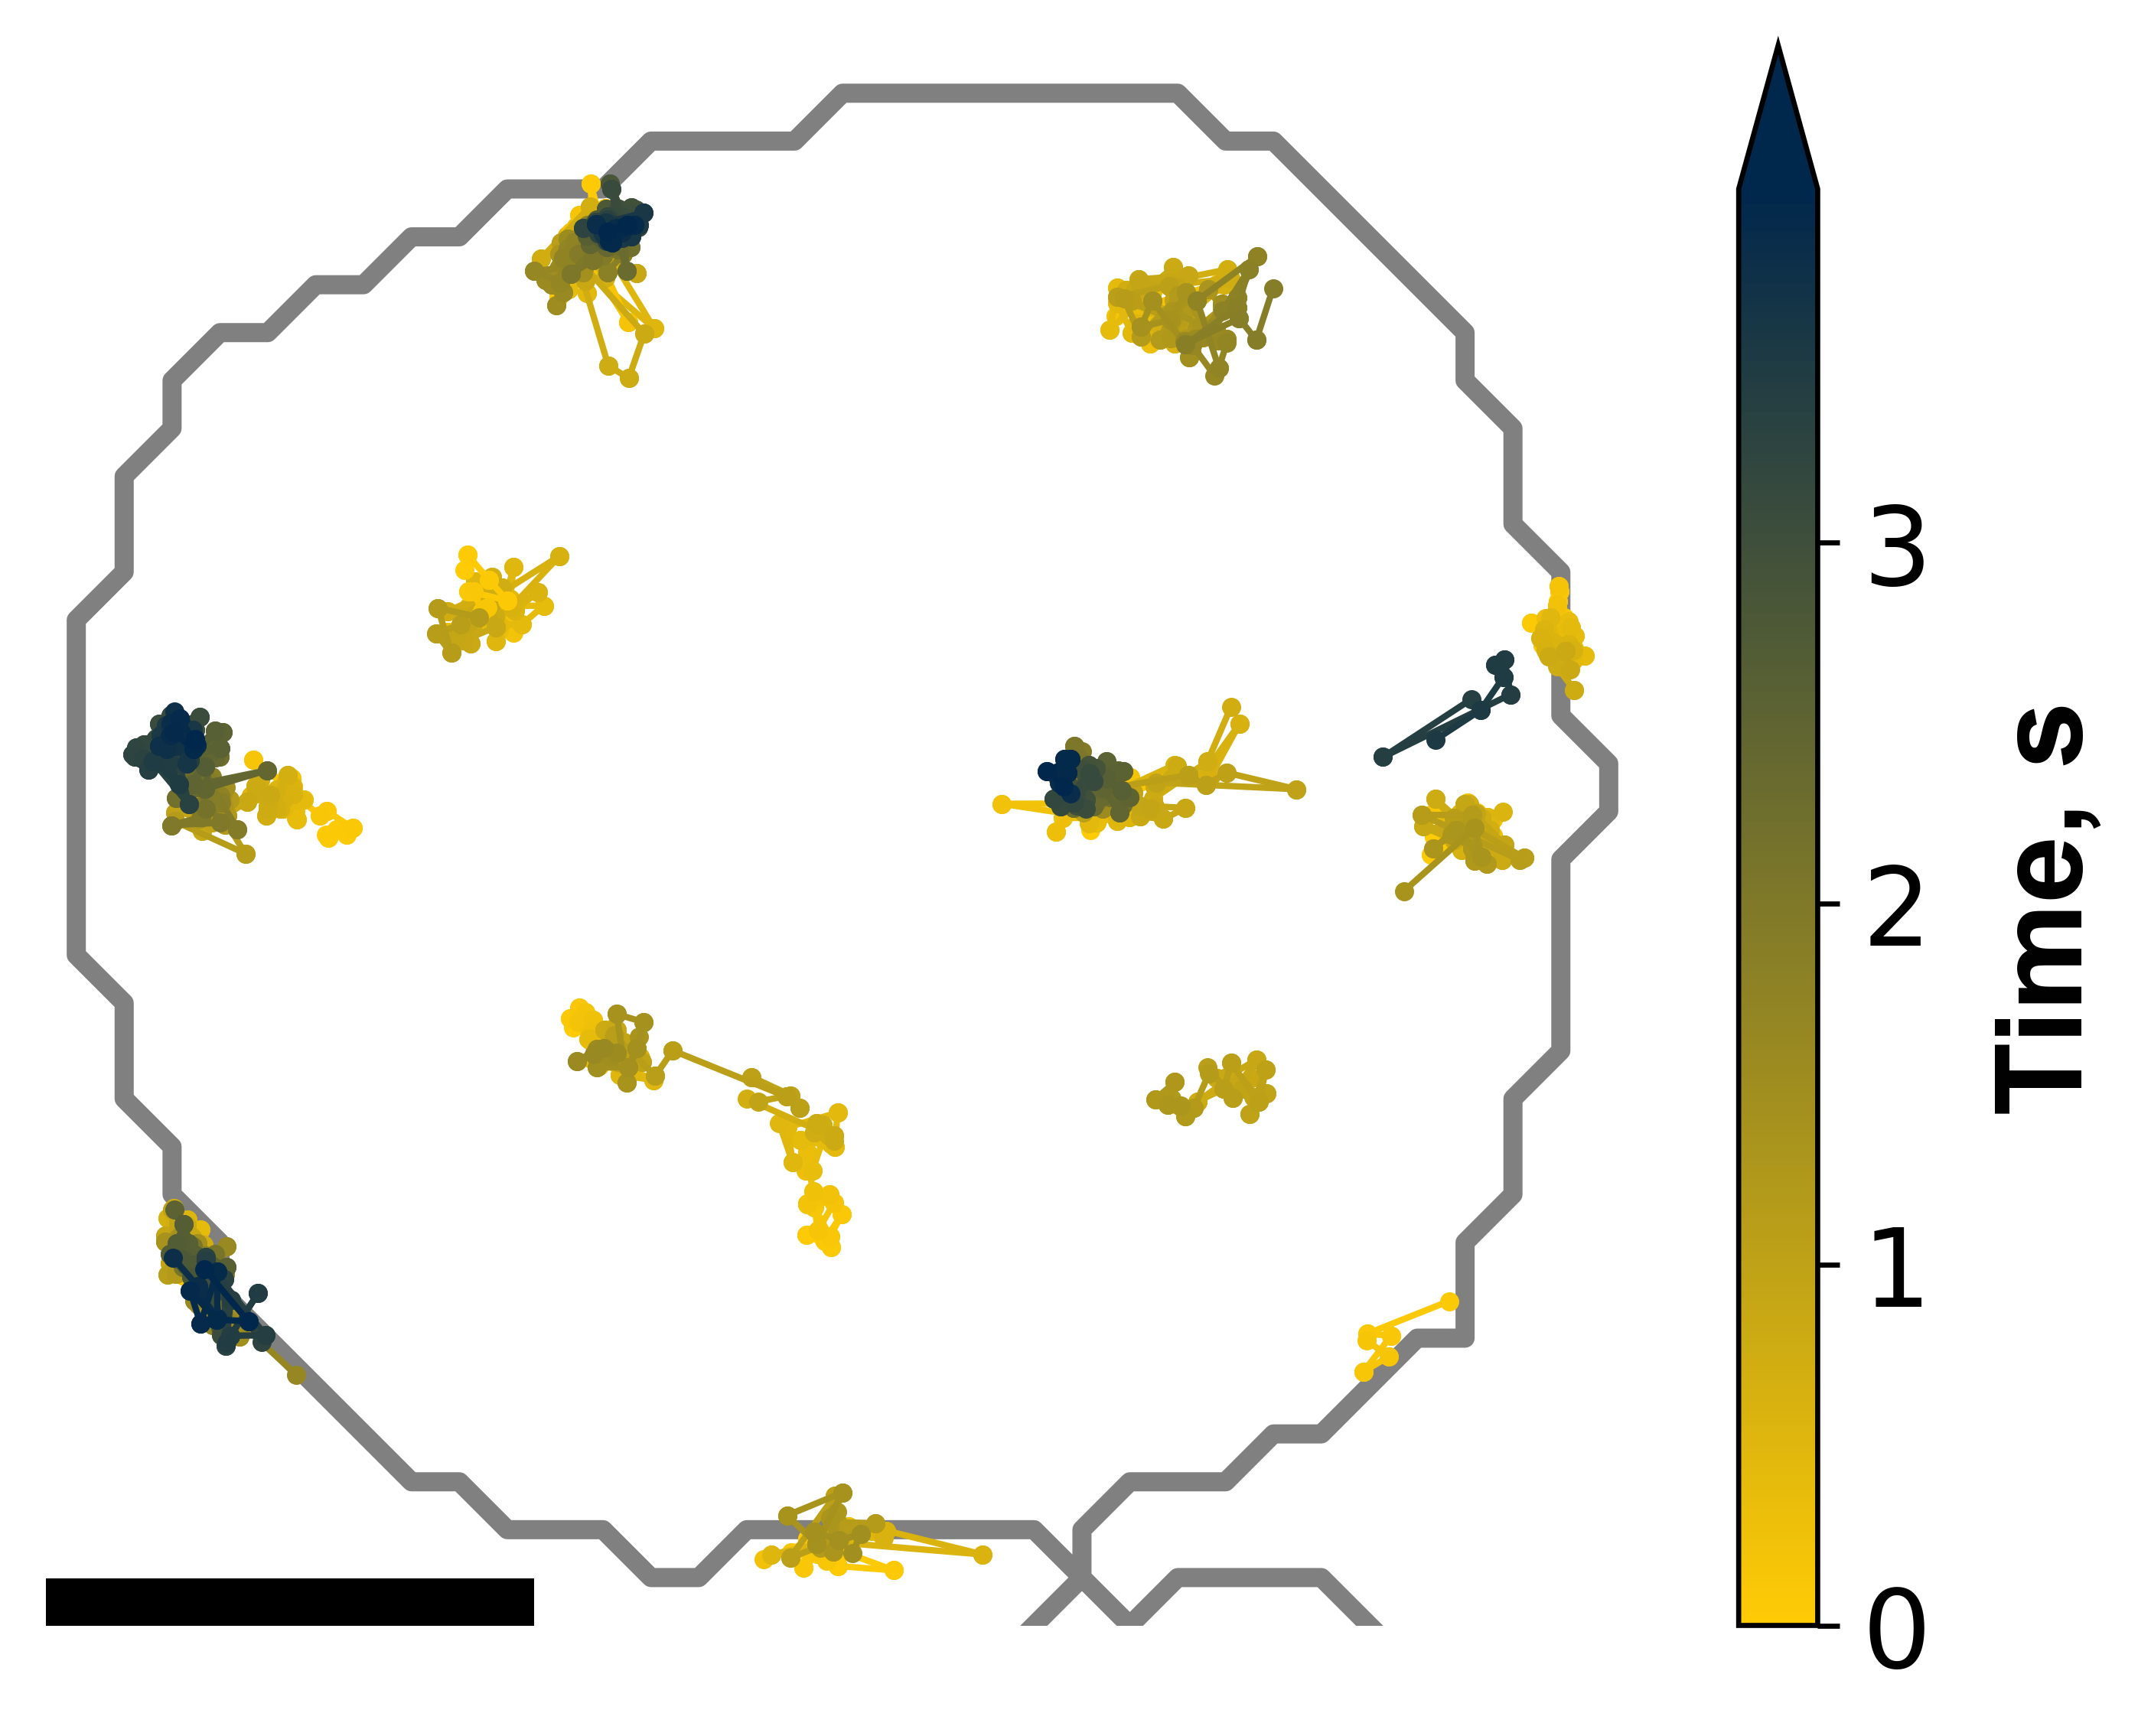

In [7]:
# full size: 418x674
zoom_in_x = (13, 45)
zoom_in_y = (297, 330)

saving_switch = True
plot_axis = False
scale_bar_offset = 0

plt.figure(dpi=600, figsize=(5, 4))
## plot condensate boundaries
for condensateID in df_condensate["condensateID"].unique():
    str_condensate_coords = df_condensate[
        df_condensate["condensateID"] == condensateID
    ]["contour_coord"].squeeze()
    x = []
    y = []
    for str_condensate_xy in str_condensate_coords[2:-2].split("], ["):
        xy = str_condensate_xy.split(", ")
        x.append(int(xy[0]))
        y.append(int(xy[1]))
    plt.plot(x, y, "-", color=line_color, linewidth=3)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color=line_color, linewidth=3)

## plot RNA tracks
t_min = 0
t_max = 0
for _, row in df_RNA.iterrows():
    x = list_like_string_to_xyt(row["list_of_x"])
    y = list_like_string_to_xyt(row["list_of_y"])
    t = list_like_string_to_xyt(row["list_of_t"])
    if (
        (x.mean() > zoom_in_x[0])
        & (x.mean() < zoom_in_x[1])
        & (y.mean() > zoom_in_y[0])
        & (y.mean() < zoom_in_y[1])
    ):
        if t.max() > t_max:
            t_max = t.max()
        for i in range(len(t) - 1):
            plt.plot(
                x[i : i + 2],
                y[i : i + 2],
                "-o",
                color=cmap(np.mean(t[i : i + 2]) / 200),
                linewidth=1,
                markersize=2,
                # alpha=0.5,
            )

plt.tight_layout()
plt.axis("equal")
if not plot_axis:
    plt.axis("off")

# plot color bar for time
cbar = plt.colorbar(
    cm.ScalarMappable(norm=clr.Normalize(0, t_max * s_per_frame), cmap=cmap),
    ax=plt.gca(),
    orientation="vertical",
    pad=0.05,
    drawedges=False,
    ticks=[0, 1, 2, 3],
    extendfrac=0.1,
    extend="max",
)
cbar.set_label(
    label="Time, s",
    weight="bold",
    fontsize=19,
    labelpad=10,
    family="Arial",
)
cbar.ax.tick_params(labelsize=17)

# plot scale bar
plt.xlim(zoom_in_x[0], zoom_in_x[1])
plt.ylim(zoom_in_y[0], zoom_in_y[1])
plt.plot(
    [
        zoom_in_x[0] + scale_bar_offset,
        zoom_in_x[0] + scale_bar_offset + scalebar_length_pxl,
    ],
    [zoom_in_y[0] + scale_bar_offset, zoom_in_y[0] + scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=15,
)

if saving_switch:
    i = 0
    fname_save = (
        "Fig1_c_boundary_w_RNAtracks_zoomin-"
        + "x_"
        + str(zoom_in_x[0])
        + "_"
        + str(zoom_in_x[1])
        + "_y_"
        + str(zoom_in_y[0])
        + "_"
        + str(zoom_in_y[1])
        + ".png"
    )
    while exists(fname_save[:-4] + "-" + str(i) + ".png"):
        i += 1
    fname_save = fname_save[:-4] + "-" + str(i) + ".png"

    plt.savefig(fname_save, format="png", bbox_inches="tight")

plt.show()